In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import trange
from parameters import fake_trace_datasets, attack_trace_datasets

In [2]:
target_train = "f4pw"
target_test = "f4pw"

byte_idx = 2

In [3]:
# ls /mnt/SCA1/CARDIS/script/fake_data/fake_08BF4*

In [4]:
# file = h5py.File("/mnt/SCA1/CARDIS/script/fake_data/fake_08BF1PW+08BF4PW.h5", "r")
# print(file["FAKE"].keys())
# file.close()

In [5]:
if target_test != target_train:
    fake = True
else:
    fake = False
print(fake)

False


In [6]:
def corr_coeff(O, P):
    n = P.size
    DO = O - (np.einsum('ij->j', O, dtype='float64') / np.double(n))
    DP = P - (np.einsum('i->', P, dtype='float64') / np.double(n))
    tmp = np.einsum('ij,ij->j', DO, DO)
    tmp *= np.einsum('i,i->', DP, DP)
    tmp = np.dot(DP, DO) / np.sqrt(tmp)
    return tmp

In [7]:
# The AES SBox that we will use to generate our labels
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

def HW(x_list):
    return np.asarray([bin(x).count("1") for x in x_list])

# Our labelization function:
# It is as simple as the computation of the result of Sbox(p[2] + k[2]) (see the White Paper)
# Note: you can of course adapt the labelization here (say if you want to attack the first byte Sbox(p[0] + k[0])
# or if you want to attack another round of the algorithm).
def labelize(plaintexts, key, hw=True):
    res = AES_Sbox[plaintexts[:] ^ key[:]]
    if hw:
        res = HW(res)
    return res

In [8]:
def get_data(target):
    target_test2 = target.upper()
    data = np.load("/mnt/SCA1/CARDIS/data_gan/stm32/translate/data/08B{}/SNR4/700/minmax/Metadata_attack.npy".format(target_test2))
    inputs = np.asarray([tmp[0][2] for tmp in data])    
    keys = np.asarray([tmp[1][2] for tmp in data])
    attack_traces = np.load("/mnt/SCA1/CARDIS/data_gan/stm32/translate/data/08B{}/SNR4/700/minmax/X_attack.npy".format(target_test2))

    return inputs, keys, attack_traces

In [9]:
def get_data_org(target):
    target_test2 = target_test.upper()
    data = h5py.File("/mnt/SCA1/CARDIS/script/trace_BD.h5", "r")
    traces = np.asarray(data["ATTACK"]["08B"+target_test2])
    data.close()
    points = {
    "08BF0PW": [[440,490], [1830,1930], [2350,2500], [3400,3800]],
    "08BF0EM": [[350,450], [1600,1800], [2200,2400], [3200,3400]],
    "08BF1PW": [[250,350], [1300,1900]],
    "08BF1EM": [[250,350], [1300,1900]],
    "08BF2PW": [[600,800], [2700,3000], [3450,3650]],
    "08BF2EM": [[600,800], [2700,3000], [3450,3650]],
    "08BF3PW": [[0, 700]],
    "08BF3EM": [[150,350], [1200,1400], [2400,2700]],
    "08BF4PW": [[500,700], [2800,3000], [3700,4000]],
    "08BF4EM": [[500,700], [2800,3000], [3700,4000]],
    "08BNANOPW": [[0,700]]
    }
    ind = points["08B"+target_test2]
    traces_ = traces[:,ind[0][0]:ind[0][1]]
    for i in range(1,len(ind)):
        traces_ = np.concatenate((traces_, traces[:,ind[i][0]:ind[i][1]]), axis=1)
    return traces_



In [10]:
def get_old_data(target_test):
    filename , trace_dset = attack_trace_datasets[target_test]
    data = h5py.File(filename, "r")[trace_dset]
    traces = np.asarray(data)
    return traces
    

In [11]:
def get_data_fake(target_train, target_test):
    target_test2 = target_test.upper()
    data = np.load("/mnt/SCA1/CARDIS/data_gan/stm32/translate/data/08B{}/SNR4/700/minmax/Metadata_attack.npy".format(target_test2))
    inputs = np.asarray([tmp[0][2] for tmp in data])    
    keys = np.asarray([tmp[1][2] for tmp in data])    

    filename , trace_dset = np.array(fake_trace_datasets[target_train][target_test])
    file = h5py.File(filename,'r')
    # use np.array to get a copy in memory to be able to close file right after
    attack_traces = np.array(file[trace_dset])
    file.close()
    return inputs, keys, attack_traces[:,:,0]

In [12]:
if fake:
    data, keys, traces = get_data_fake(target_train, target_test)
else:
    data, keys, traces = get_data(target_test)
#     traces_org = get_old_data(target_test)

In [13]:
 "/mnt/SCA1/CARDIS/data_gan/stm32/translate/data/08B{}/SNR4/700/minmax/".format(target_test.upper())

'/mnt/SCA1/CARDIS/data_gan/stm32/translate/data/08BF4PW/SNR4/700/minmax/'

In [14]:
ls /mnt/SCA1/CARDIS/data_gan/stm32/translate/data/08BF2EM/SNR4/700/minmax/

Metadata_attack.npy*     X_attack.npy*     Y_attack.npy*
Metadata_profiling.npy*  X_profiling.npy*  Y_profiling.npy*


In [15]:
if target_train == "f2em":
    steper = range(2,60,2)
elif target_train == "f3em":
    steper = range(2,25000,2000)
elif target_train == "f4em":
    steper = range(2,1000,10)
#     steper = range(2,25000,2000)
elif target_train == "f0em":
     steper = range(2,1000,10)
elif target_train == "f1em":
     steper = range(2,1000,10)
elif "pw" in target_train:
    steper = range(2,25,1)
else:
    print("Not implemented")

In [16]:
corr = np.empty((len(steper),256,traces.shape[1]))

In [17]:
for key in trange(256):
    label = labelize(data,key^keys)
    ind = 0
    for t in steper:
        corr[ind,key,:] = corr_coeff(traces[:t,:], label[:t])
        ind = ind + 1

  0%|          | 0/256 [00:00<?, ?it/s]<ipython-input-6-32c5036c803e>:7: RuntimeWarning: invalid value encountered in true_divide
  tmp = np.dot(DP, DO) / np.sqrt(tmp)
100%|██████████| 256/256 [00:03<00:00, 66.37it/s]


In [18]:
steper

range(2, 25)

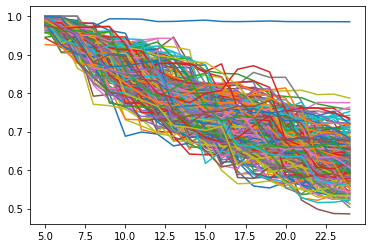

In [19]:
corr_max = np.max(np.abs(corr),2)
plt.plot(steper,corr_max[:,:]);

In [20]:
# if not fake:
#     for key in trange(256):
#         label = labelize(data,key^keys)
#         ind = 0
#         for t in steper:
#             corr[ind,key,:] = corr_coeff(traces_org[:t,:], label[:t])
#             ind = ind + 1
#     corr_max_org = np.max(np.abs(corr),2)
#     plt.plot(steper,corr_max_org[:,:]);

In [21]:
if fake:
    res = { "corr_max": corr_max, "steper": steper}
else:
#     res = { "corr_max": corr_max,"corr_max_org": corr_max_org, "steper": steper} 
    res = { "corr_max": corr_max, "steper": steper}

In [22]:
np.save("/mnt/SCA1/CARDIS/results_CPA/fake_{}_{}.npy".format(target_train,target_test),res)

In [23]:
ls /mnt//SCA1/CARDIS/results_CPA/

fake_f0pw_f0pw.npy*  fake_f2em_f2em.npy*  fake_f4em_f4em.npy*
fake_f0pw_f0pw.png*  fake_f2em_f2em.png*  fake_f4em_f4em.png*
fake_f0pw_f2pw.npy*  fake_f2em_f2pw.npy*  fake_f4em_f4pw.npy*
fake_f0pw_f2pw.png*  fake_f2em_f2pw.png*  fake_f4em_f4pw.png*
fake_f1pw_f1pw.npy*  fake_f2pw_f2pw.npy*  fake_f4pw_f0pw.npy*
fake_f1pw_f1pw.png*  fake_f2pw_f2pw.png*  fake_f4pw_f0pw.png*
fake_f1pw_f2pw.npy*  fake_f2pw_f4pw.npy*  fake_f4pw_f4pw.npy*
fake_f1pw_f2pw.png*  fake_f2pw_f4pw.png*


In [24]:
ls /mnt/SCA1/CARDIS/data_gan/stm32/translate/data/08BF0PW/SNR4/700/minmax/


Metadata_attack.npy*     X_attack.npy*     Y_attack.npy*
Metadata_profiling.npy*  X_profiling.npy*  Y_profiling.npy*


In [25]:
# test = np.load("/mnt/SCA1/CARDIS/data_gan/stm32/translate/data/08BF0PW/SNR4/700/minmax/Metadata_profiling.npy")

In [26]:
# ls /mnt/SCA1/CARDIS/script/fake_data/fake_08BF1EM*

In [27]:
# file.keys()

In [28]:
# corr_max = np.max(np.abs(corr),2)
# plt.plot(steper,corr_max[:,:]);

In [29]:
np.argmax((np.max(np.abs(corr),2)),1)

array([  0,   0,   0,   8,  73, 146,  70,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0])